In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io
import PIL.Image as Image
from math import sqrt
import PNP_solver


In [2]:
solver = PNP_solver.PoseEstimator()

In [2]:
mat = "552 325 565 316 580 316 593 322 580 328 565 329 674 321 687 314 704 314 718 322 704 328 688 327 854 270 -74.224602 58.624695 -17.821962 -0.109297 0.191268 -0.001372 4.607621 -21.929678 530.719849 -27.992239 -21.538828 537.017151 37.207481 -22.320528 524.422546"
mat = mat.split(" ")
mat = np.array(list(map(lambda kek: float(kek), mat)))
faceModel = scipy.io.loadmat("MPIIGaze/6 points-based face model.mat")
faceModel = np.array(faceModel['model'])
faceModel = faceModel.transpose()
cameraCalib = scipy.io.loadmat('MPIIGaze/Data/Original/p00/Calibration/Camera.mat')
img = Image.open("MPIIGaze/Data/Original/p00/day01/0001.jpg")
print(faceModel)

[[-4.50967681e+01 -4.83773045e-01  2.39702984e+00]
 [-2.13128582e+01  4.83773045e-01 -2.39702984e+00]
 [ 2.13128582e+01  4.83773045e-01 -2.39702984e+00]
 [ 4.50967681e+01 -4.83773045e-01  2.39702984e+00]
 [-2.62995769e+01  6.85950353e+01 -9.86076132e-32]
 [ 2.62995769e+01  6.85950353e+01 -9.86076132e-32]]


In [4]:
headpose_hr = np.array(mat[29:32])
headpose_ht = np.array(mat[32:35])
hR, _ = cv2.Rodrigues(headpose_hr)
matrix = np.zeros((3, 4))
matrix[:, :3] = hR
matrix[:, 3] = headpose_ht
Fc = []
for i in range(6):
    Fc.append(np.matmul(matrix, [*(faceModel[i]), 1]))
Fc = np.array(Fc)
Fc[1]-Fc[2], solver.model_points_68[39] - solver.model_points_68[42]
cameraCalib

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Oct 14 14:11:03 2016',
 '__version__': '1.0',
 '__globals__': [],
 'cameraMatrix': array([[994.73532636,   0.        , 624.66344095],
        [  0.        , 998.16646784, 364.08742557],
        [  0.        ,   0.        ,   1.        ]]),
 'distCoeffs': array([[-0.16321888,  0.66783406, -0.00121854, -0.00303158, -1.02159927]]),
 'retval': array([[0.48423145]]),
 'rvecs': array([[-3.65982097e-01, -4.44470363e-01, -8.07540181e-02],
        [-3.94010818e-02,  5.56557963e-01,  1.61485301e+00],
        [-6.54604372e-01,  3.28707994e-01,  6.11190401e-02],
        [-5.62157528e-01,  3.74032131e-01, -2.02997565e-03],
        [-4.59252548e-01, -6.24683579e-01, -9.61582975e-02],
        [ 2.39905048e-01,  5.03739931e-01, -2.60053297e-01],
        [-4.73112062e-01,  8.53846532e-01,  1.36534861e-01],
        [-8.37490358e-01,  1.39534037e-02, -5.01882209e-02],
        [ 2.89496167e-01,  6.23870509e-01, -2.16827454e-01],
    

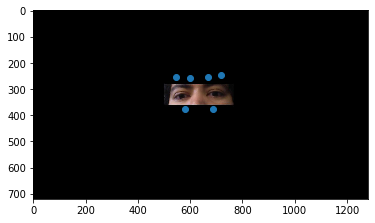

In [5]:
plt.imshow(img)
kek, _ = cv2.projectPoints(faceModel, headpose_hr, headpose_ht, cameraCalib['cameraMatrix'], cameraCalib['distCoeffs'])
kek = kek.reshape((-1, 2)).transpose()
plt.scatter(*kek)

In [6]:
right_eye_center = 0.5*(Fc[0]+Fc[1])
left_eye_center = 0.5*(Fc[2]+Fc[3])
right_eye_center, left_eye_center

(array([-27.9632215 , -58.81032089, 537.59814734]),
 array([ 36.17759228, -59.87380489, 526.62344136]))

In [7]:
gaze_target = np.array(mat[26:29])

In [8]:
eye_image_width  = 36
eye_image_height = 60

In [9]:
def norm(target_3D):
    return np.sqrt(np.matmul(target_3D, target_3D))
def normalizeImg(inputImg, target_3D, hR, gc, roiSize, cameraMatrix, focal_new=960, distance_new=600):
    distance = np.sqrt(np.matmul(target_3D, target_3D))
    #np.seterr(divide='ignore', invalid='ignore')
    z_scale = distance_new/distance
    cam_new = np.array([[focal_new, 0, roiSize[1]/2], [0.0, focal_new, roiSize[0]/2], [0, 0, 1.0]])
    scaleMat = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, z_scale]]
    hRx = hR[:,0]
    forward = (target_3D/distance)
    down = np.cross(forward, hRx)
    down = down / norm(down)
    right = np.cross(down, forward)
    right = right / norm(right)
    rotMat = np.array([right, down, forward])
    warpMat = np.matmul(np.matmul(cam_new, scaleMat), np.matmul(rotMat, np.linalg.inv(cameraMatrix) ))
    roiSize = np.array(roiSize, dtype=np.float32)
    warpMat = np.array(warpMat, dtype=np.float32)
    inputImg = np.array(inputImg) 
    img_warped = cv2.warpPerspective(inputImg, warpMat, (60, 36))
    cnvMat = scaleMat @ rotMat
    hRnew = cnvMat @ hR
    hrnew, _ = cv2.Rodrigues(hRnew)
    vect = gc - target_3D
    vect = vect/norm(vect)
    htnew = cnvMat @ target_3D
    gcnew = cnvMat @ gc
    gvnew = cnvMat @ vect
    gvnew = gvnew / norm(gvnew)
    print(vect)
    inv_cnv_mat = np.linalg.inv(cnvMat)
    vect = inv_cnv_mat @ gvnew
    print(vect/norm(vect))
    print(gvnew)
    return img_warped, hrnew, gvnew
def denormalize(gvnew, target_3D, hR, distance_new=600):
    distance = np.sqrt(np.matmul(target_3D, target_3D))
    #np.seterr(divide='ignore', invalid='ignore')Z
    z_scale = distance_new/distance
    scaleMat = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, z_scale]]
    hRx = hR[:,0]
    forward = (target_3D/distance)
    down = np.cross(forward, hRx)
    down = down / norm(down)
    right = np.cross(down, forward)
    right = right / norm(right)
    rotMat = np.array([right, down, forward])
    cnvMat = scaleMat @ rotMat
    inv_cnv_mat = np.linalg.inv(cnvMat)
    vect = inv_cnv_mat @ gvnew
    print(vect/norm(vect))
    return vect/norm(vect)

[-0.08122001  0.20617788 -0.97513794]
[-0.08122001  0.20617788 -0.97513794]
[-0.12264459  0.08546617 -0.98876379]
[-0.08122001  0.20617788 -0.97513794]


array([-0.08122001,  0.20617788, -0.97513794])

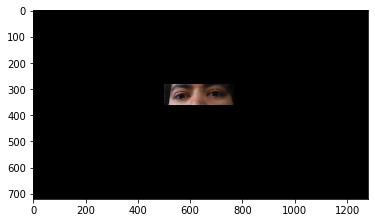

In [28]:
eye_img, headpose, gaze = normalizeImg(img, right_eye_center, hR, gaze_target, [eye_image_width, eye_image_height], cameraCalib['cameraMatrix']);
plt.imshow(img)
denormalize(gaze, right_eye_center, hR)

[-0.08219037  0.14251205 -0.9863747 ]<br>
[-0.08219037  0.14251205 -0.9863747 ]<br>
[-0.12202546  0.0901101  -0.98842802 ]<br>
[-0.08219037  0.14251205 -0.9863747 ]


array([-0.12202543,  0.09011014, -0.98842802])

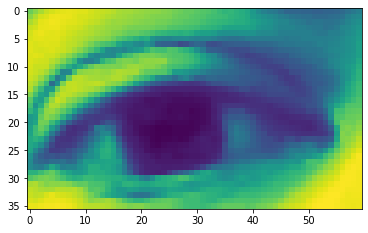

In [32]:
kke = scipy.io.loadmat("MPIIGaze/Data/Normalized/p00/day01.mat")
img = kke['data'][0][0][0][0][0][1][0]
plt.imshow(img)
kke['data'][0][0][0][0][0][0][0]



In [12]:
gaze

array([-0.12264459,  0.08546617, -0.98876379])